In [22]:
using LinearAlgebra

---

# AD using operator overloading

https://julialang.zulipchat.com/#narrow/stream/225542-helpdesk/topic/Comparing.20julia.20and.20numpy/near/209135246

This is similar to the approach used by `ForwardDiff.jl`.

In [23]:
# f(a+bɛ) := f(a) + b f'(a) ɛ
#
# f(Dual(a,b)) = Dual(f(a),b*f'(a))
#
# f(Dual(a,1)) = Dual(f(a),f'(a))

struct Dual{T} <: Number where {T <: Real}
    p::T
    d::T
end

Dual(p,d) = Dual(promote(p,d)...)

Dual

In [24]:
import Base: promote_rule, convert, show

promote_rule(::Type{Dual{T}}, ::Type{<:Real}) where T<:Real = Dual{T}

convert(::Type{Dual{T}}, x::Real) where T<:Real = Dual(x,zero(T))

show(io::IO, d::Dual) = print(io, "$(d.p) + $(d.d)*ε")

ε = Dual(0, 1)

0 + 1*ε

In [25]:
import Base: +, -, *, /, inv

# Sum rule
+(x::Dual, y::Dual) = Dual(x.p + y.p, x.d + y.d)

# Difference rule
-(y::Dual) = Dual(-y.p, -y.d)
-(x::Dual, y::Dual) = x + -y

# Product rule
*(x::Dual, y::Dual) = Dual(x.p*y.p, x.d*y.p + x.p*y.d)

# Quotient rule
inv(y::Dual) = Dual(1/y.p, -y.d/y.p^2)
/(x::Dual, y::Dual) = x*inv(y)

/ (generic function with 132 methods)

In [26]:
f(x) = (x^4 + x^3)/(x^2 + x + 1)

z = f(1.0 + ε)

0.6666666666666666 + 1.6666666666666665*ε

In [27]:
fp(x) = f(x + ε).d

fp (generic function with 1 method)

In [28]:
fp(1.0)

1.6666666666666665

In [29]:
using Plots

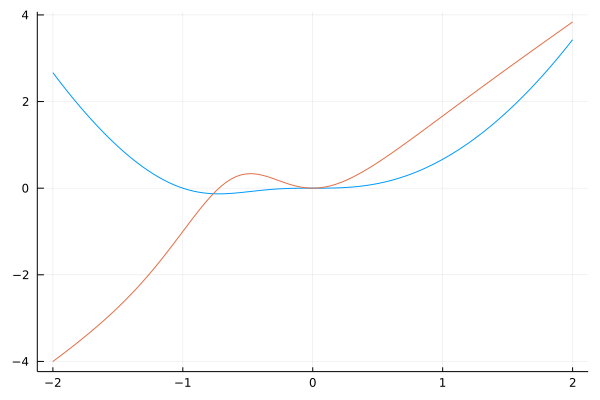

In [31]:
xx = range(-2, 2, length=100)
plot(legend=:none)
plot!(xx, f.(xx))
plot!(xx, fp.(xx))

---

# Zygote.jl

The Zygote provides source-to-source automatic differentiation.

In [1]:
using Zygote

In [35]:
f(x) = x^4 + x^3

f'(1.0)

7.0

In [36]:
fp(x) = 4x^3 + 3x^2

fp(1.0)

7.0

In [37]:
@code_llvm fp(1.0)

;  @ In[36]:1 within `fp'
define double @julia_fp_7661(double %0) {
top:
; ┌ @ intfuncs.jl:313 within `literal_pow'
; │┌ @ operators.jl:560 within `*' @ float.jl:332
    %1 = fmul double %0, %0
    %2 = fmul double %1, %0
; └└
; ┌ @ promotion.jl:322 within `*' @ float.jl:332
   %3 = fmul double %2, 4.000000e+00
   %4 = fmul double %1, 3.000000e+00
; └
; ┌ @ float.jl:326 within `+'
   %5 = fadd double %4, %3
; └
  ret double %5
}


In [38]:
@code_llvm f'(1.0)

;  @ /Users/krislock/.julia/packages/Zygote/lwmfx/src/compiler/interface.jl:62 within `#43'
define double @"julia_#43_7663"(double %0) {
top:
; ┌ @ /Users/krislock/.julia/packages/Zygote/lwmfx/src/compiler/interface.jl:59 within `gradient'
; │┌ @ /Users/krislock/.julia/packages/Zygote/lwmfx/src/compiler/interface.jl:41 within `#41'
; ││┌ @ In[35]:1 within `Pullback'
; │││┌ @ /Users/krislock/.julia/packages/ZygoteRules/OjfTt/src/adjoint.jl:59 within `#1757#back'
; ││││┌ @ /Users/krislock/.julia/packages/Zygote/lwmfx/src/lib/number.jl:6 within `#214'
; │││││┌ @ intfuncs.jl:312 within `literal_pow'
; ││││││┌ @ float.jl:332 within `*'
         %1 = fmul double %0, %0
; │││││└└
; │││││┌ @ promotion.jl:322 within `*' @ float.jl:332
        %2 = fmul double %1, 3.000000e+00
; │││││└
; │││││┌ @ intfuncs.jl:313 within `literal_pow'
; ││││││┌ @ operators.jl:560 within `*' @ float.jl:332
         %3 = fmul double %1, %0
; │││││└└
; │││││┌ @ promotion.jl:322 within `*' @ float.jl:332
        %4 = 

---

# AD of neural net using Zygote

In [39]:
ReLU(γ) = max(0, γ)

ReLU (generic function with 1 method)

In [57]:
# Parameters
A = [ 1 0; -2 1 ]
b = [ 1, 0 ]
c = [ 1, 1 ]

# put parameters in a named tuple
p = (A=A, b=b, c=c)

(A = [1 0; -2 1], b = [1, 0], c = [1, 1])

In [58]:
p.A

2×2 Matrix{Int64}:
  1  0
 -2  1

In [64]:
# Neural net
function predict(p, x)
    y = p.A*x + p.b
    z = ReLU.(y)
    w = p.c'z
end

# Loss function
loss(w, w̄) = (w - w̄)^2

loss (generic function with 1 method)

In [72]:
# Data
x = rand(-3:3, 2) # [1, 1]

2-element Vector{Int64}:
  2
 -2

In [73]:
w = predict(p, x)

3

In [74]:
w̄ = 1

loss(w, w̄)

4

In [75]:
f(p) = loss(predict(p,x), w̄)

f (generic function with 1 method)

In [76]:
∇f(p) = gradient(f, p)[1]

∇f (generic function with 1 method)

In [77]:
∇f(p)

(A = [8 -8; 0 0], b = [4, 0], c = [12, 0])

---